In [1]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torchvision.transforms as T
import torchvision.datasets as datasets
from typing import List
import cv2
from torch import Tensor
from sklearn.preprocessing import MinMaxScaler

import cv2
import numpy as np
from skimage import feature
import scipy.stats
from skimage.feature import hog

class FeatureExtractor:
    def __init__(self):
        self.scaler_ =  MinMaxScaler()
    
    def __call__(self, imgs: List[Tensor]):
        data = [self.__extract_features(img) for img in imgs]
        data = self.scaler_.fit_transform(data)
        
        return data
    
    def __extract_features(self, image):
        image = image.permute(1, 2, 0).numpy()
        image = np.round(image * 255).astype(np.uint8)
        
        # Colors
        mean_colors = np.mean(image, axis=(0,1))
        
        # Color histogram
        hist_size = 16
        b_hist = cv2.calcHist([image], [0], None, [hist_size], (0, 256), accumulate=False)
        g_hist = cv2.calcHist([image], [1], None, [hist_size], (0, 256), accumulate=False)
        r_hist = cv2.calcHist([image], [2], None, [hist_size], (0, 256), accumulate=False)
        
        hist = np.concatenate([b_hist, g_hist, r_hist]).flatten()
        
        # Hu Moments
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        moments = cv2.moments(gray_image)
        hu_moments = cv2.HuMoments(moments)
        hu_moments = -np.sign(hu_moments) * np.log10(np.abs(hu_moments))
        
        # Additional features
        mean_values = np.mean(image, axis=(0, 1))
        std_values = np.std(image, axis=(0, 1))
        skewness_values = [scipy.stats.skew(hist)]
        kurtosis_values = [scipy.stats.kurtosis(hist)]
        
        # Hog features
        hog_features = hog(gray_image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(1, 1))
        
        # Edges
        edges = cv2.Canny(gray_image, threshold1=30, threshold2=100)
        edge_density = [np.sum(edges) / (edges.shape[0] * edges.shape[1])]
    
        # Concatenate all features
        features = np.concatenate([
            mean_colors[:2],
            hist,
            mean_values, 
            std_values, 
            skewness_values, 
            kurtosis_values,
            hog_features,
            edge_density,
            hu_moments.flatten()
        ])
        
        return features

In [2]:

transform = T.Compose([T.ToTensor()])
dataset_tr = datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
dataset_te = datasets.CIFAR10(root='../data', train=False, download=True, transform=transform)

fe = FeatureExtractor()
# imgs = [img for img, label in dataset_tr if label == 0]
# labels = [label for _, label in dataset_tr if label == 0]
imgs = [img for img, label in dataset_tr]
labels = [label for _, label in dataset_tr]

data = fe(imgs)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
from sklearn.cluster import OPTICS, SpectralClustering, KMeans
from collections import Counter

# optics = OPTICS(min_samples=2, min_cluster_size=20)
optics = SpectralClustering(n_clusters=18)
clusters = optics.fit_predict(data)

counter = Counter(clusters)
print(sorted(dict(counter).items(), key=lambda item: item[1], reverse=True))

Explained Variance Ratio: [0.12735227 0.06123795]


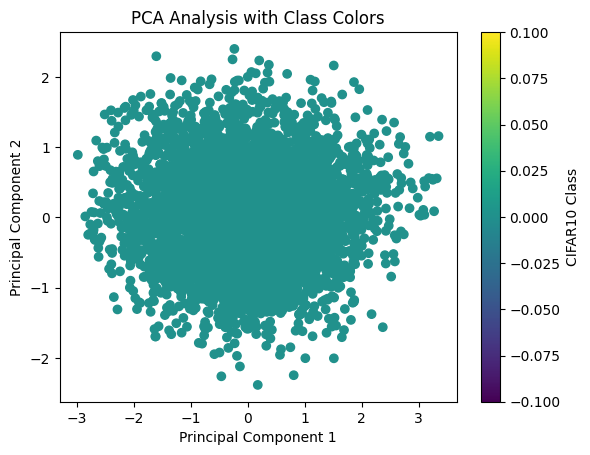

In [ ]:
# Applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data)

explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:", explained_variance_ratio)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.title("PCA Analysis with Class Colors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='CIFAR10 Class')
plt.show()

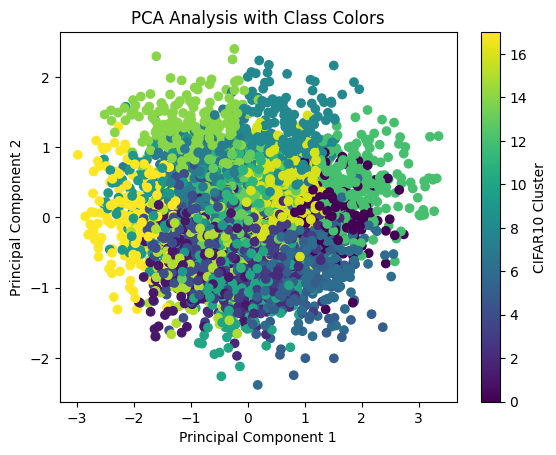

In [ ]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title("PCA Analysis with Class Colors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label='CIFAR10 Cluster')
plt.show()